# Supplemental Figure 2 — Overview of the gating strategy used to gate for single E. coli cells.

---
Unless explicitly noted otherwise (e.g. indicated as being from Zenodo), all data used for the visualisations was generated using the Illumina or Nanopore pipeline.


Please make sure to download the input dataset `Flow_cytometry_raw_data` from the Zenodo repository and place it in a folder named `data` at root repository level.

For more information, please refer to the `README.md`

### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A) </strong>Overview of the gating strategy used to gate for single E. coli cells.</div>  

## Figure S2A: Overview of the gating workflow used to analyze reporter expression in E. coli populations expressing AraC-LOV variants.
----------------------------

**Note:** The following analysis uses the `cytoflow` package, which is incompatible with modern versions of `seaborn`, `matplotlib`, and `numpy`.  To avoid conflicts, run the Cytoflow section in a **separate virtual environment**.

You can create and activate the required environment as follows:

```bash
# Add the Cytoflow conda channel
conda config --add channels bpteague

# Create and activate the environment
conda create --name cf cytoflow notebook
conda activate cf


#### Notebook Setup

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [1]:
# --- Import necessary modules ---
import cytoflow
from cytoflow import *
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import math
from pathlib import Path

notebook_dir = Path().resolve()
repo_root = notebook_dir.parent 
sys.path.append(str(repo_root))


# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})


In [2]:
# --- Import FACS Data ---
op_0 = ImportOp(
    conditions={'CF_File': 'category'}, # Define metadata column
    tubes=[
        # Each Tube corresponds to one .fcs file (one sample)
        # `conditions` adds a label to each tube for grouping
        Tube(
            file=
            f'{repo_root}/data/Flow_cytometry_raw_data/01_sd2_AraC_WT_blue_light.fcs',
            conditions={'CF_File': '01_sd2_AraC_WT_blue_light'}),
        Tube(
            file=
           f'{repo_root}/data/Flow_cytometry_raw_data/10_sd2_AraC_S170_R2_LOV_1_Arabinose_blue_light.fcs',
            conditions={
                'CF_File': '10_sd2_AraC_S170_R2_LOV_1_Arabinose_blue_light'
            })],
    # Rename FACS channels to readable names
    channels={
        'FSC-A': 'FSC_A',
        'FSC-H': 'FSC_H',
        'SSC-A': 'SSC_A',
        'SSC-H': 'SSC_H',
        'Y610-A': 'Y610_A', # Fluorescence channel
    })

# Apply the import operation and load data into an experiment object
ex_0 = op_0.apply()

# --- Gate for E. coli population ---
op_1 = PolygonOp(name='Ecoli',
                 xchannel='SSC_A',
                 ychannel='FSC_A',
                 vertices=[(1357.9732606179289, 275.05545196062917),
                           (3096.358586276033, 130.4833062471451),
                           (30016.169863090054, 22463.177752089905),
                           (21981.80211486695, 58220.89159406637),
                           (742.6137843756184, 6004.526015249525),
                           (818.5434737539503, 698.6374935564252)],
                 xscale='log',
                 yscale='log')

# Apply E. coli gating to data
ex_1 = op_1.apply(ex_0)

# --- Gate for singlet cells ---
op_2 = PolygonOp(name='Singlets',
                 xchannel='SSC_A',
                 ychannel='SSC_H',
                 vertices=[(720.9528536391655, 715.2244917579866),
                           (2415.7462968326668, 1718.2013652044473),
                           (81537.30363552464, 51916.855303397606),
                           (54488.91914190919, 63080.21963700783),
                           (575.8161707505337, 949.4559941564318)],
                 xscale='log',
                 yscale='log')

# Apply singlet gating
ex_2 = op_2.apply(ex_1)

# --- Filter gated population ---
# Keep only events that passed both 'Ecoli' and 'Singlets' gates
ex_2.data = ex_2.data[ex_2.data['Ecoli']==True]
ex_2.data = ex_2.data[ex_2.data['Singlets']==True]
# --- Downsample ---
# Take a random sample of 15,000 events per CF_File to normalize cell counts
ex_2.data = ex_2.data.groupby('CF_File').apply(lambda x: x.sample(15000)).reset_index(drop=True)
# --- Compute statistics ---
# Calculate the median fluorescence (Y610_A) per sample
stats = ex_2.data.groupby(['CF_File']).median().reset_index()

colors = ['#93959866', '#0075BF66']

/Users/alicehovsepyan/opt/miniconda3/envs/cf/lib/python3.6/site-packages/cytoflow/utility/log_scale.py:117: RuntimeWarning: invalid value encountered in log10


In [4]:
def FACS_hist(title, input_samples, label_names, colors, stats):
    # --- Plot aesthetics ---
    sns.set(style="white")
    sns.set(font_scale=1.5)
    sns.set_style('ticks')
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.rcParams["axes.linewidth"] = 3
    plt.rcParams["xtick.major.width"] = 3
    plt.rcParams["xtick.minor.width"] = 3
    plt.rcParams["ytick.major.width"] = 3   
    plt.xlabel('log[RFP]')

    # --- Subset data ---
    subset = ex_2.data[ex_2.data['CF_File'].isin(input_samples)].copy()
    subset['Y610_A'].replace(0, 0.001, inplace=True)
    subset['Y610_A'] = pd.to_numeric(subset['Y610_A'], errors='coerce')
    plt.gca().set_xlim((1, max(subset['Y610_A'])))

    # --- Custom legend ---
    handles = [Patch(facecolor=color, label=label) for label, color in zip(label_names, colors)]

    # --- Filled KDE curves (with color) ---
    sns.kdeplot(
        data=subset,
        x='Y610_A',
        hue=subset['CF_File'].cat.remove_unused_categories(),
        cut=0,
        fill=True,
        common_norm=False,
        alpha=0.4,
        log_scale=True,
        palette=colors,
        linewidth=0
    )

    # --- Overlay black KDE outlines manually for each sample ---
    for input_sample in input_samples:
        subset_single = subset[subset['CF_File'] == input_sample]
        sns.kdeplot(
            data=subset_single,
            x='Y610_A',
            cut=0,
            fill=False,
            common_norm=False,
            log_scale=True,
            color='black',
            linewidth=3
        )

    sns.despine()

    # --- Legend ---
    plt.legend(handles=handles, labels=label_names, frameon=False, loc='center', bbox_to_anchor=(1.3, 0.5))

    # --- Median lines ---
    for input_sample in input_samples:
        median = stats[stats['CF_File'] == input_sample]['Y610_A'].iloc[0]
        print(stats[stats['CF_File'] == input_sample]['Y610_A'])
        plt.axvline(x=median, color='black', linewidth=2)

    # --- Limits ---
    plt.ylim(0, 1.75)
    plt.xlim(1, 10_000_000)

    plt.show()

/Users/alicehovsepyan/opt/miniconda3/envs/cf/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Avenir Next'] not found. Falling back to DejaVu Sans.
/Users/alicehovsepyan/opt/miniconda3/envs/cf/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Avenir Next'] not found. Falling back to DejaVu Sans.


(10, 100000)

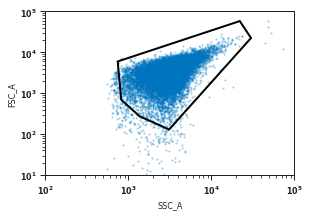

In [5]:
op_1 = PolygonOp(name='Ecoli',
                 xchannel='SSC_A',
                 ychannel='FSC_A',
                 vertices=[(1357.9732606179289, 275.05545196062917),
                           (3096.358586276033, 130.4833062471451),
                           (30016.169863090054, 22463.177752089905),
                           (21981.80211486695, 58220.89159406637),
                           (742.6137843756184, 6004.526015249525),
                           (818.5434737539503, 698.6374935564252)],
                 xscale='log',
                 yscale='log')

ex_1 = op_1.apply(ex_0)
op_1.default_view(subset=f'(CF_File == "10_sd2_AraC_S170_R2_LOV_1_Arabinose_blue_light") ').plot(ex_1, color='#0075BF66')
plt.xlim([100, 100000])
plt.ylim([10, 100000])
# plt.savefig('HEK293T_gate.svg', bbox_inches='tight')

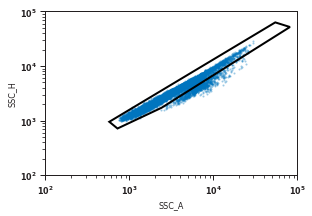

In [6]:
op_2 = PolygonOp(name='Singlets',
                 xchannel='SSC_A',
                 ychannel='SSC_H',
                 vertices=[(720.9528536391655, 715.2244917579866),
                           (2415.7462968326668, 1718.2013652044473),
                           (81537.30363552464, 51916.855303397606),
                           (54488.91914190919, 63080.21963700783),
                           (575.8161707505337, 949.4559941564318)],
                 xscale='log',
                 yscale='log')

ex_2 = op_2.apply(ex_1)
op_2.default_view(
    subset='(CF_File == "01_sd2_AraC_WT_blue_light") and (Ecoli == True)',
    huefacet='CF_File').plot(ex_1, xlim=(100.0, 100000), ylim=(100.0, 100000), legend=False, color='#0075BF66')
# plt.savefig('singlet_gate.svg', bbox_inches='tight')